## Расчитываем кластеры (графы) проектов

## Расчет дополнительных коэффициентов.  

В предыдущем пункте был почитан коэффициент по формуле koef = count / scatter. 
В таблице ниже стоит другой koef, на него можно не смотреть.
Для дальнейшего анализа необходимо получить дополнительные коэффициенты (таблица ниже):

- forward_confidence - вероятность покупки товара pair с товаром model в один и тот же день. Считается по формуле koef / count. Например, в таблице ниже видно, что Если клиент покупает Лестницу, то Перчатки будут куплены вместе с ней с вероятностью 0.512686%.
- back_confidence - обратный коэффициент уже для Перчаток - лестниц (скорее справочный). То есть видно, что при покупке лестниц вероятно купят перчатки, но при покупке печаток маловероятна покупка лестницы.
- reciprocity - коэффициент взаимности. reciprocity = back_confidence к forward_confidence. То есть по сути, коэффициент говорит о том, насколько товары обуславливают покупку друг друга.
- koef - reciprocity / forward_confidence. 



In [1]:
import pandas as pd
df = pd.read_pickle('sales/pregraph.pkl').rename(columns={'Name_x':'model_name', 'Name_y':'pair_name'})
df['price_difference'] = df['model_median'] / df['pair_median']


df.head(5)

,model,pair,model_name,pair_name,count,avg,forward_confidence,back_confidence,reciprocity,back_avg,koef,model_median,pair_median,price_difference
0,MOD_200001,MOD_200652,Лестницы раскладные и универсальные,Перчатки,8002,0.750062,0.512686,0.00868405,0.0169384,-0.180614,0.00710144,4254.24,55.93,76.063651
1,MOD_200003,MOD_200652,Аксессуары для лестниц,Перчатки,69,4.057971,0.584746,7.48812e-05,0.000128058,-0.897959,0.00390454,2125.42,55.93,38.001430
2,MOD_200005,MOD_200652,Бетоносмесители электрические,Перчатки,4389,3.235589,0.514899,0.0047631,0.00925055,-1.736134,0.00457788,7316.10,55.93,130.808153
3,MOD_200007,MOD_200652,Бытовые и профессиональные строительные леса,Перчатки,775,3.120000,0.742337,0.000841057,0.00113299,-1.874046,0.00826305,2131.67,55.93,38.113177
4,MOD_200008,MOD_200652,Вышки-туры,Перчатки,2139,0.906966,0.61982,0.00232132,0.00374515,-0.831259,0.0122595,5222.03,55.93,93.367245


In [ ]:
select = ["model_name", "pair_name", "count", 
          "forward_confidence", 
          "price_difference",
         ]

df[df["model_name"] == "Водяной радиатор"][select].sort_values(by="count", ascending=False).reset_index(drop=True)

### Графы проектов

In [2]:
# Медианы цен товаров из моделей адео

medians = df[['model_name', 'model_median']].drop_duplicates().to_dict(orient='records')
medians = {x['model_name']: x['model_median'] for x in medians}
medians['Водяной радиатор']


6268.475

### Граф основных связей базовый

На этом графе выберем топ категрий-пар для категории Кухонный шкаф, просто чтобы посмотреть, что чаще всего покупают вместе. 

['Комплект для сборки плинтусов', 'Планка для столешниц и стеновых панелей', 'Петли для кухонных фасадов', 'Мойка', 'Смеситель для кухни', 'Аксессуары для установки кухонного цоколя', 'Фасад кухонного шкафа', 'Фальшпанель для шкафа', 'Сушилка для посуды', 'Мебельная ручка', 'Стеновая панель', 'Кромка столешницы и стеновой панели', 'Ящики для кухни', 'Столешница кухонная', 'Цоколь для кухни']


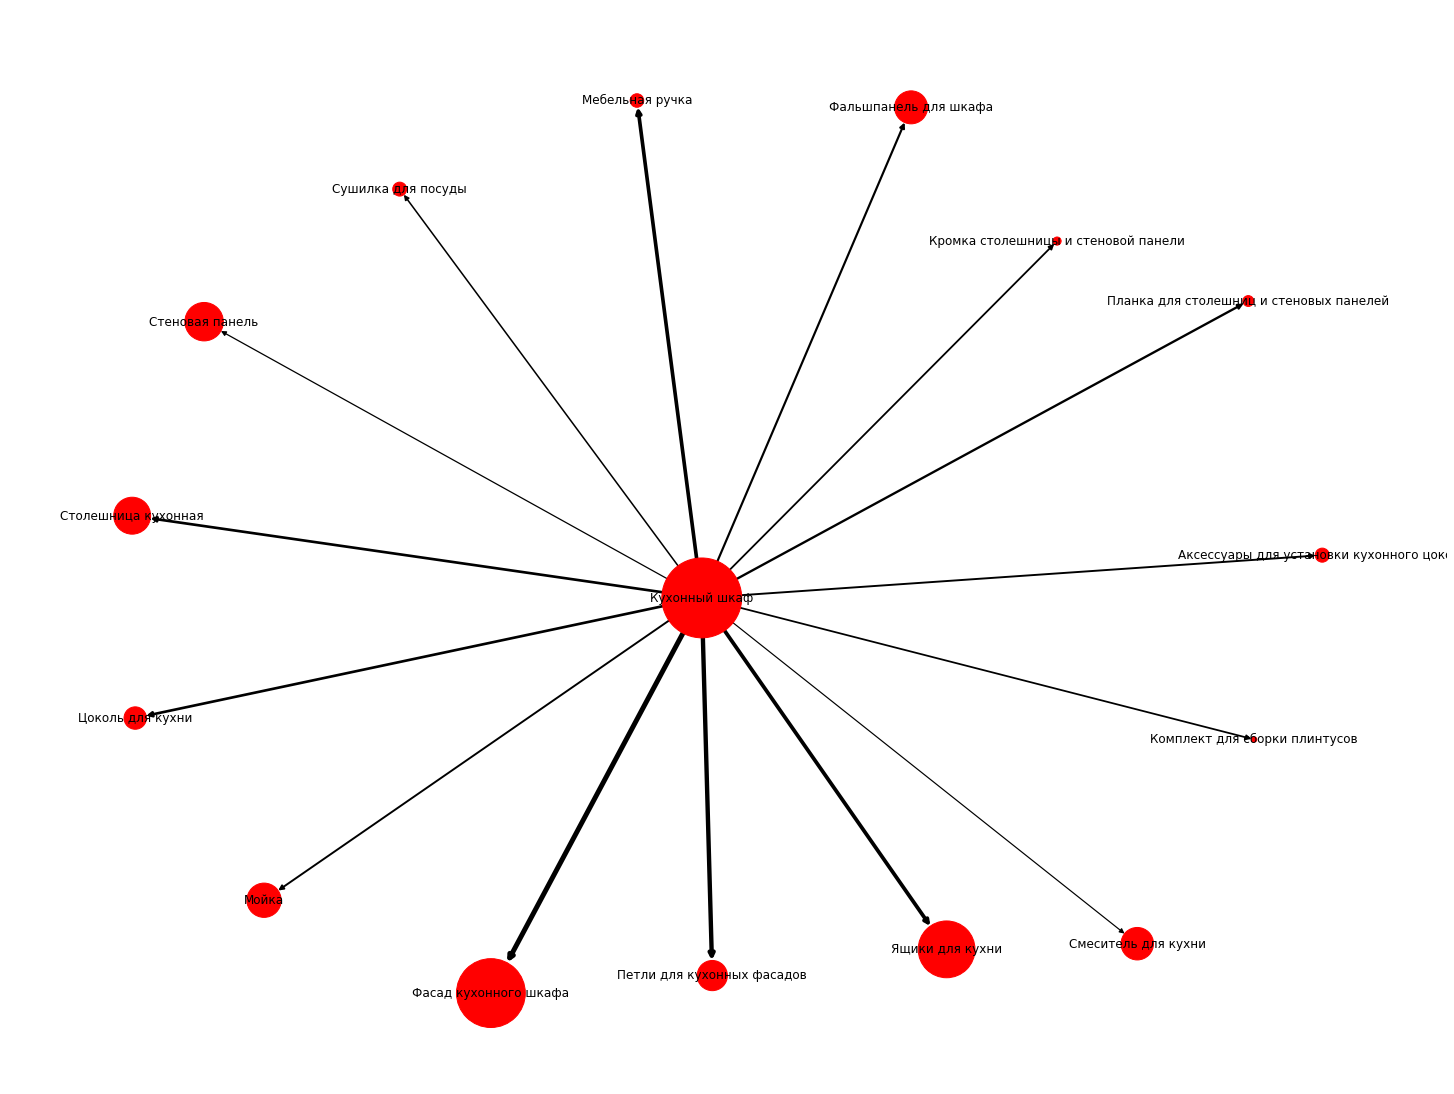

In [7]:
models = ["Кухонный шкаф"]
max_conf = 0.20

from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(20,15))

def get_edges(df, model, max_conf):
    pairs = df[df['model_name'] == model]
    pairs = pairs[pairs['forward_confidence'] > max_conf]
    pairs_dict = pairs[['model_name', 'pair_name', 'forward_confidence']].to_dict(orient='records')
    return pairs_dict

g = nx.DiGraph(directed=True)


edges = []
nodes = [models[0]]


edges_dict = []
tmp_df = df[['model_name', 'pair_name', 'forward_confidence']] 

for i in range(1):
    for m in models:
        if i == 0:
            edges_dict += get_edges(tmp_df, m, max_conf)
        else:
            e = get_edges(tmp_df, m, max_conf)
            e = [eg for eg in e if eg['pair_name'] in nodes]
            edges_dict += e
    models = list(set([e['pair_name'] for e in edges_dict if e['pair_name'] not in nodes]))
    print(models)
    nodes += [e['pair_name'] for e in edges_dict]

edges = pd.DataFrame([{'model_name': e['model_name'], 'pair': e['pair_name'], 'weight': e['forward_confidence']} for e in edges_dict])
new_edges = []
new_nodes = []
for e, edf in edges.groupby('model_name'):
    edf = edf.sort_values(by='weight', ascending=False).iloc[:, :]
    new_edges += [(e['model_name'], e['pair'], {'weight': e['weight']}) for e in edf.to_dict(orient='records')]
    new_nodes += list(edf['model_name'])
    new_nodes += list(edf['pair'])


new_nodes = list(set(new_nodes))
    
g.add_nodes_from(new_nodes)
g.add_edges_from(new_edges)

pos=nx.spring_layout(g)

# print(nodes)

nx.draw(g, pos,
        with_labels=True,
        node_color = 'r', 
        node_size = [medians[n]/2 for n in new_nodes],
        width=[e[2]['weight']*5 for e in new_edges],
        alpha=1
       )
plt.draw()
plt.show()

### Теперь пробуем кластеризовать проект Кухонного Шкафа следующими этапами:

- Получаем коэффициент связи между всеми товарами друг с другом.
- Для каждого товара оставляем только одну самую сильную связь, остальные удаляем.

Как правило, после этой процедуры все связанные товары делятся на небольшие связные подгруппы.



['Газовая варочная панель', 'Мебельная ручка', 'Электрическая варочная панель', 'Поддон под мойку', 'Столешница кухонная', 'Посудомоечная машина', 'Комплект для сборки плинтусов', 'Петли для кухонных фасадов', 'Смеситель для кухни', 'Фасад кухонного шкафа', 'Сушилка для посуды', 'Кромка столешницы и стеновой панели', 'Выдвижная корзина для шкафа', 'Планка для столешниц и стеновых панелей', 'Вытяжка и кухонный воздухоочиститель', 'Слив для умывальника или биде', 'Сифон для мойки', 'Мебельный карниз для кухни', 'Фальшпанель для шкафа', 'Аксессуары для установки кухонного цоколя', 'Мойка', 'Стеновая панель', 'Ящики для кухни', 'Цоколь для кухни', 'Духовой шкаф']
[]
[]


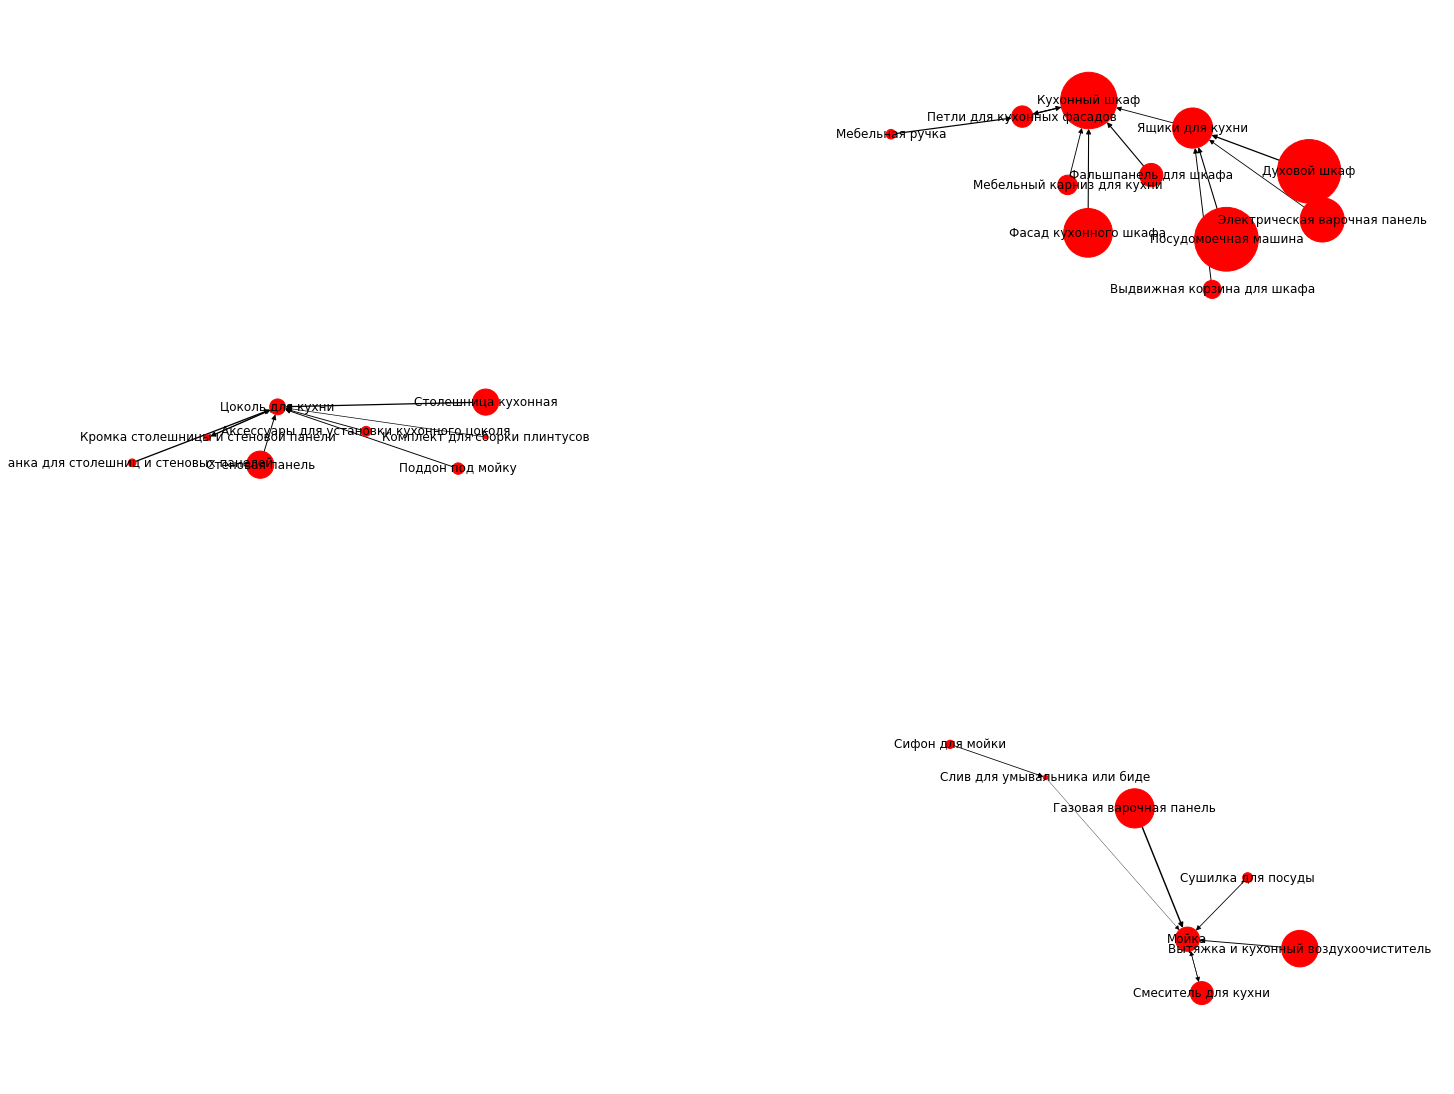

In [11]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(20,15))

def get_edges(df, model, max_conf):
    pairs = df[df['model_name'] == model]
#     pairs['koef'] = pairs['koef'] / pairs['koef'].max()
    pairs = pairs[pairs['koef'] > max_conf]
    pairs_dict = pairs[['model_name', 'pair_name', 'koef']].to_dict(orient='records')
    return pairs_dict

g = nx.DiGraph(directed=True)


# models = ['Камеры видеонаблюдения']
# models = ["Водяной радиатор"]
models = ["Кухонный шкаф"]

edges = []
nodes = [models[0]]

max_connections = 1


max_conf = 0.015

edges_dict = []
tmp_df = df[['model_name', 'pair_name', 'koef']] 
for i in range(3):
    for m in models:
        if i < 1:
            edges_dict += get_edges(tmp_df, m, max_conf)
        else:
            e = get_edges(tmp_df, m, max_conf)
            e = [eg for eg in e if eg['pair_name'] in nodes]
            edges_dict += e
    models = list(set([e['pair_name'] for e in edges_dict if e['pair_name'] not in nodes]))
    print(models)
    nodes += [e['pair_name'] for e in edges_dict]

edges = pd.DataFrame([{'model_name': e['model_name'], 'pair': e['pair_name'], 'weight': e['koef']} for e in edges_dict])
new_edges = []
new_nodes = []
for e, edf in edges.groupby('model_name'):
    edf = edf.sort_values(by='weight', ascending=False).iloc[:max_connections, :]
    new_edges += [(e['model_name'], e['pair'], {'weight': e['weight']}) for e in edf.to_dict(orient='records')]
    new_nodes += list(edf['model_name'])
    new_nodes += list(edf['pair'])


new_nodes = list(set(new_nodes))
    
g.add_nodes_from(new_nodes)
g.add_edges_from(new_edges)

pos=nx.spring_layout(g)

# print(nodes)

nx.draw(g, #pos,
        with_labels=True,
        node_color = 'r', 
        node_size = [medians[n] / 4 for n in new_nodes],
        width=[e[2]['weight']*2 for e in new_edges],
        alpha=1
       )
plt.draw()
plt.show()

In [ ]:
models